In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy import log, exp
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as T
sns.set_style("white")
%load_ext rpy2.ipython

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Fitting a mixed effect model Poisson GLM with ADVI mini_batch

1. Regularize using GLM Lasso
    - The first step in the analysis is, for each study, to fit a regularizing GLM LASSO to help identify the primary factors driving pig movement.  Particularly, we want to see how foraging resources affect pig movement as main effects and as interactive effects with other available resources.

2. Fit a mixed effect model using ADVI
    - Once we've identified a simple minimalish model, we want to more robustly extract the population-level effects by fitting a mixed effects model in which we allow random effects of individuals. We will use Mini-batch ADVI to fit these models, hopefully without losing too much realism in the predictions.  This will be a good way to include error in the predictions
    

In [2]:
tejondat = pd.read_csv("/Users/mqwilber/Repos/rsf_swine/results/glmdata_by_study/tejon.csv")

In [181]:
pigattrib = pd.read_csv("/Users/mqwilber/Repos/rsf_swine/data/formatted/pig_attributes.csv")[['pigID', "sex"]]
tejondat = pd.merge(tejondat, pigattrib, on="pigID")

In [183]:
Xtej = pd.read_csv("../results/temp_Xgam_tej.csv")

In [186]:
Xtej = Xtej.drop(columns=['(Intercept)'])

In [184]:
from sklearn.preprocessing import StandardScaler

include_vars = ["crw", 
                "canopycover_loc", "canopycover_grad",
                "water_loc",
                "ndvi_loc", 
                "masting_loc", 
                "crop_loc",
                "crop_grad",
                "precipitation_loc", "temperature_loc"]

interactions = ["canopycover_loc:temperature_loc",
                "canopycover_grad:temperature_loc",
                "masting_loc:precipitation_loc", 
                "temperature_loc:precipitation_loc:water_loc",
                "water_loc:temperature_loc",
                "ndvi_loc:crop_loc"]


## NOTE: See Buderman et al. 2018.  I potentially should standardize for each pig separately rather than all of them 
## simultaneously.

z = tejondat.z.values
tau = tejondat.tau.values

# Build the design matrix
X = pd.DataFrame(StandardScaler().fit_transform(X=tejondat[include_vars].values))
X.columns = include_vars

# Include interactions

Xint = pd.DataFrame(np.array([np.cumprod(X[inter.split(":")].values, axis=1)[:, -1] for inter in interactions]).T)
Xint.columns = interactions
Xfull = pd.concat([X, Xint], axis=1)
Xfull = pd.concat([Xfull, pd.get_dummies(tejondat.sex)[['M']]], axis=1)
Xfull = Xfull.rename(columns={'M': "sex"})

# Drop main effects of temperature and precip
Xfull =  Xfull.drop(columns=["temperature_loc", "precipitation_loc"])


pigIDs = pd.Series(tejondat.pigID)
unqpigIDs = pd.Series(pigIDs.unique()).reset_index()
unqpigIDs.columns = ['pigID_index', 'pigID']
pigIDs_num = pd.merge(pd.DataFrame(pigIDs), unqpigIDs, on="pigID").pigID_index

Z = pd.get_dummies(tejondat.pigID)

Zfull = Xfull.crop_loc.values[:, np.newaxis] * Z
Zfull2 = Xfull.crop_grad.values[:, np.newaxis] * Z

Build a PyMC3 model using MiniBatch.

In [187]:
import theano
import theano.tensor

Xfull = Xtej
poisson_model = pm.Model()
numparams = Xfull.shape[1]

batch = 1000
X_t = pm.Minibatch(Xfull.values, batch)
z_t = pm.Minibatch(z, batch)
tau_t = pm.Minibatch(tau, batch)
Z_t = pm.Minibatch(Zfull.values, batch)
Z2_t = pm.Minibatch(Zfull2.values, batch)

numrand = 2

# pigID_t = pm.Minibatch(pigIDs_num, batch)
numpigs = len(np.unique(tejondat.pigID))

with poisson_model:

    # Hyper priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=3, shape=numparams)
    sigma_a = pm.HalfCauchy("sigma_a", beta=2)
    phi_vect = pm.Lognormal('phi_vect', mu=0, sd=0.04, shape=numrand - 1)
    sigma_vect = sigma_a * phi_vect
    sigma_full = T.concatenate([T.stack(sigma_a), sigma_vect])
    
    # Random effect of individual pig on crop_loc
    a = pm.Normal('a', mu=0, sd=sigma_full[0], shape=numpigs)
    
    # Random effect of individual pig on crop_grad
    b = pm.Normal('b', mu=0, sd=sigma_full[1], shape=numpigs)
    
    # Expected value of outcome
    loglam = log(tau_t) + alpha + theano.dot(X_t, beta) + theano.dot(Z_t, a) + theano.dot(Z2_t, b)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Poisson('Y_obs', mu=np.exp(loglam), observed=z_t, total_size=Xfull.shape[0])

In [191]:
with poisson_model:
    inference = pm.ADVI()
    modfit = pm.fit(n=40000, method="advi", 
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 8.0117e+10:   5%|▍         | 1884/40000 [03:43<1:15:14,  8.44it/s]
Interrupted at 1,884 [4%]: Average Loss = 4.6958e+11


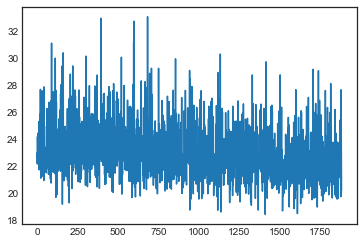

In [192]:
plt.plot(np.log(modfit.hist))

In [156]:
trace = modfit.sample(draws=10000)

In [159]:
coef = pm.summary(trace)
coef.loc[:, "names"] = ["intercept"] +  list(Xfull.columns) + list(range(13)) + list(range(13)) + ['sigma_a'] + ['phi']
coef

,mean,sd,mc_error,hpd_2.5,hpd_97.5,names
alpha,-8.223434,0.010386,0.000105,-8.243360,-8.202352,intercept
beta__0,0.705864,0.009787,0.000094,0.687188,0.725375,crw
beta__1,-0.275250,0.009966,0.000105,-0.295047,-0.255825,canopycover_loc
beta__2,0.007025,0.008903,0.000088,-0.011227,0.023149,canopycover_grad
beta__3,-0.133988,0.009407,0.000090,-0.152275,-0.115590,water_loc
beta__4,-0.234044,0.010392,0.000101,-0.255183,-0.214524,ndvi_loc
beta__5,-0.495682,0.010879,0.000108,-0.517528,-0.474881,masting_loc
beta__6,-0.165946,0.010529,0.000099,-0.186879,-0.145519,crop_loc
beta__7,-0.114611,0.008543,0.000089,-0.131325,-0.098051,canopycover_loc:temperature_loc
beta__8,0.039987,0.007781,0.000078,0.024627,0.054958,canopycover_grad:temperature_loc


## Time-varying pig movement

First fitting Tejon trajectories

In [165]:
Xtej_gam = pd.read_csv("../results/temp_Xgam_tej.csv")

In [175]:
gam_model = pm.Model()

numparams = Xtej_gam.shape[1]

batch = 1000
X_t = pm.Minibatch(Xtej_gam.values, batch)
z_t = pm.Minibatch(z, batch)
tau_t = pm.Minibatch(tau, batch)

with gam_model:

    # Hyper priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Normal('beta', mu=0, sd=1, shape=numparams)
    
    loglam = log(tau_t) + alpha + theano.dot(X_t, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Poisson('Y_obs', mu=np.exp(loglam), observed=z_t, total_size=Xtej_gam.shape[0])

In [176]:
# Fit the Tejon GAM model
with gam_model:
    tej_inference = pm.ADVI()
    tej_gam = pm.fit(n=40000, method="advi", 
                callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 7.2948e+09:   0%|          | 24/40000 [00:05<2:32:26,  4.37it/s]
Interrupted at 24 [0%]: Average Loss = 7.7018e+09


In [167]:
Xtej_gam.shape

(787320, 49)

In [177]:
Xtej_gam.mean(axis=0)

crw_z             0.000000
sexM              0.311258
hour_2            0.232626
hour_3            0.107256
hour_4            0.096047
hour_5            0.290658
month_1           0.294783
month_2           0.179124
month_4           0.131572
month_5           0.284762
cover_loc_1      -0.121597
cover_loc_2      -0.028810
cover_loc_3       0.063239
cover_loc_4       0.073328
cover_loc_5       0.013840
cover_grad_1      0.000000
cover_grad_2      0.000000
cover_grad_3      0.000000
cover_grad_4      0.000000
cover_grad_5      0.000000
water_loc_1       0.008950
water_loc_2      -0.002165
water_loc_3       0.012705
water_loc_4       0.022857
water_loc_5      -0.042347
water_grad_2      0.000000
water_grad_5      0.000000
crop_loc_1        0.121118
crop_loc_2        0.073570
crop_loc_3       -0.000841
crop_loc_4       -0.094952
crop_loc_5       -0.098895
crop_grad_3       0.000000
crop_grad_4       0.000000
masting_loc_1     0.054018
masting_loc_3     0.022999
masting_loc_4    -0.006282
m